# 4.0 Backtrader Backtest

Run and analyze the short strategy using backtrader for realistic simulation.

**Settings:**
- Cheat-on-close enabled (same-day execution)
- Per-share commission ($0.003/share)
- No DD scaling (pure signal)
- News-only filtering

**Expected Results:**
- ~+85% return, Sharpe ~0.69 over 14 months

In [1]:
import sys
sys.path.insert(0, '.')

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Configuration

In [2]:
from trading.bt_runner import run_backtest
from trading.config import DEFAULT_CONFIG

# Model path - use dropout optimized model
MODEL_PATH = Path('data/model_simple_returns.pt')
DATA_DIR = Path('data')

# Date range - TEST SET (model was trained on data before 2024-10-22)
START_DATE = '2024-10-22'
END_DATE = '2025-12-18'

# Base options
INITIAL_CASH = 100_000

## 2. Run Baseline Backtest

In [ ]:
%%time

result = run_backtest(
    model_path=MODEL_PATH,
    data_dir=DATA_DIR,
    start_date=START_DATE,
    end_date=END_DATE,
    initial_cash=INITIAL_CASH,
    use_dd_scaling=False,
    use_confidence=False,
    news_only=True,
)

print(f"\n{'='*60}")
print("BASELINE RESULTS")
print('='*60)
print(f"Return:     {result.total_return*100:+.1f}%")
print(f"Sharpe:     {result.sharpe_ratio:.2f}")
print(f"Max DD:     {result.max_drawdown*100:.1f}%")
print(f"Trades:     {result.n_trades}")
print(f"Final:      ${result.final_value:,.0f}")

INFO - Starting backtest
INFO -   Model: data/model_simple_returns.pt
INFO -   Data: data
INFO -   Period: 2024-10-22 to 2025-12-18
INFO - Loaded model from data/model_simple_returns.pt
INFO -   Price features: 9
INFO -   Fund features: 19
INFO -   Embedding dims: 768
INFO - Loading price data from data/prices.pqt...
INFO -   Loaded 5,888,410 rows
INFO -   Splitting into per-symbol DataFrames...
INFO -     Processed 1,000/5,644 symbols...
INFO -     Processed 2,000/5,644 symbols...
INFO -     Processed 3,000/5,644 symbols...
INFO -     Processed 4,000/5,644 symbols...
INFO -     Processed 5,000/5,644 symbols...
INFO -   Done: 5,644 symbols loaded
INFO - Adding data feeds to cerebro...
INFO -   Processed 1,000/5,644 symbols (887 added)...
INFO -   Processed 2,000/5,644 symbols (1,787 added)...
INFO -   Processed 3,000/5,644 symbols (2,685 added)...
INFO -   Processed 4,000/5,644 symbols (3,570 added)...
INFO -   Processed 5,000/5,644 symbols (4,444 added)...
INFO -   Done: 5,019 data fe

## 3. Risk Management Variants

In [9]:
configs = [
    {"name": "Baseline", "max_volatility": None, "use_inverse_vol": False},
    {"name": "Vol Filter (max 100%)", "max_volatility": 1.0, "use_inverse_vol": False},
    {"name": "Vol Filter (max 75%)", "max_volatility": 0.75, "use_inverse_vol": False},
    {"name": "Inverse-Vol Sizing", "max_volatility": None, "use_inverse_vol": True},
    {"name": "Vol<100% + InvVol", "max_volatility": 1.0, "use_inverse_vol": True},
]

print(f"Testing {len(configs)} configurations...")

Testing 5 configurations...


In [ ]:
%%time

results = []

for i, cfg in enumerate(configs):
    print(f"\n[{i+1}/{len(configs)}] {cfg['name']}...")
    
    res = run_backtest(
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
        max_volatility=cfg['max_volatility'],
        use_inverse_vol=cfg['use_inverse_vol'],
    )
    
    print(f"  Return={res.total_return*100:+.1f}%, Sharpe={res.sharpe_ratio:.2f}, MaxDD={res.max_drawdown*100:.1f}%")
    
    results.append({
        'name': cfg['name'],
        'return': res.total_return,
        'sharpe': res.sharpe_ratio,
        'max_dd': res.max_drawdown,
        'n_trades': res.n_trades,
    })

INFO - Starting backtest
INFO -   Model: data/model_simple_returns.pt
INFO -   Data: data
INFO -   Period: 2024-10-22 to 2025-12-18
INFO - Loaded model from data/model_simple_returns.pt
INFO -   Price features: 9
INFO -   Fund features: 19
INFO -   Embedding dims: 768
INFO - Loading price data from data/prices.pqt...



[1/5] Baseline...


INFO -   Loaded 5,888,410 rows
INFO -   Splitting into per-symbol DataFrames...
INFO -     Processed 1,000/5,644 symbols...
INFO -     Processed 2,000/5,644 symbols...
INFO -     Processed 3,000/5,644 symbols...
INFO -     Processed 4,000/5,644 symbols...
INFO -     Processed 5,000/5,644 symbols...
INFO -   Done: 5,644 symbols loaded
INFO - Adding data feeds to cerebro...
INFO -   Processed 1,000/5,644 symbols (887 added)...
INFO -   Processed 2,000/5,644 symbols (1,787 added)...
INFO -   Processed 3,000/5,644 symbols (2,685 added)...
INFO -   Processed 4,000/5,644 symbols (3,570 added)...
INFO -   Processed 5,000/5,644 symbols (4,444 added)...
INFO -   Done: 5,019 data feeds added (625 skipped)
INFO - Loading features from data/ml_dataset.pqt...
INFO -   Loaded 2,092,929 rows, 804 columns
INFO -   Filtered to 464,188 rows for 2,765 symbols
INFO -   Filtered to news-only: 127,325 rows (27.8% of 458,094)
INFO - Computing volatility features from prices...
INFO -   Computed volatility fo

In [13]:
# Results summary
results_df = pd.DataFrame(results)
results_df['return_pct'] = results_df['return'] * 100
results_df['max_dd_pct'] = results_df['max_dd'] * 100

print("="*70)
print("RISK MANAGEMENT COMPARISON")
print("="*70)
print()
print(results_df[['name', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))
print()

# Best config
best_idx = results_df['sharpe'].idxmax()
best = results_df.loc[best_idx]
print(f"Best by Sharpe: {best['name']}")
print(f"  Sharpe={best['sharpe']:.2f}, Return={best['return_pct']:.1f}%")

RISK MANAGEMENT COMPARISON

                 name  return_pct    sharpe  max_dd_pct  n_trades
             Baseline  119.389705  0.738743   71.652010       951
Vol Filter (max 100%)    0.976527  0.171115   42.070506       936
 Vol Filter (max 75%)  -15.264503 -0.763327   41.517468       985
   Inverse-Vol Sizing   68.860653  0.639288   61.299118       951
    Vol<100% + InvVol   -1.197369 -0.414564   39.376631       936

Best by Sharpe: Baseline
  Sharpe=0.74, Return=119.4%


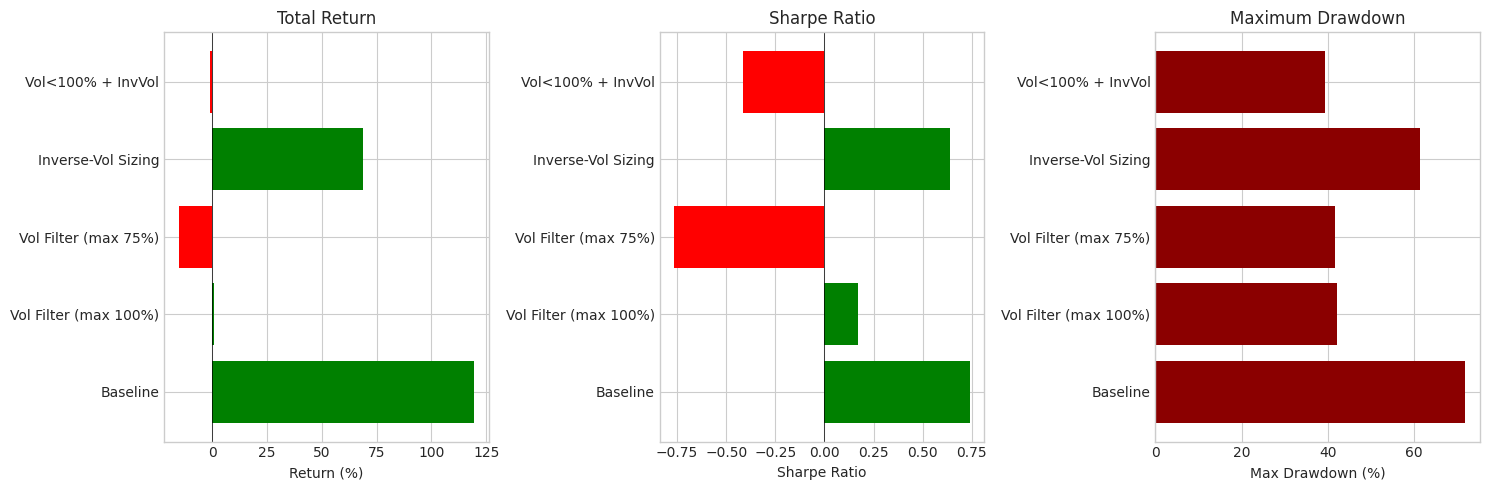

In [14]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Returns
ax = axes[0]
colors = ['green' if x > 0 else 'red' for x in results_df['return_pct']]
ax.barh(results_df['name'], results_df['return_pct'], color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Return (%)')
ax.set_title('Total Return')

# Sharpe
ax = axes[1]
colors = ['green' if x > 0 else 'red' for x in results_df['sharpe']]
ax.barh(results_df['name'], results_df['sharpe'], color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

# Max DD
ax = axes[2]
ax.barh(results_df['name'], results_df['max_dd_pct'], color='darkred')
ax.set_xlabel('Max Drawdown (%)')
ax.set_title('Maximum Drawdown')

plt.tight_layout()
plt.show()